In [1]:
library('depmixS4')
library('quantmod')
library('xts')
set.seed(1)

Warning message:
"package 'depmixS4' was built under R version 3.5.2"Loading required package: nnet
Loading required package: MASS
Loading required package: Rsolnp
Warning message:
"package 'Rsolnp' was built under R version 3.5.2"Loading required package: xts
Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Loading required package: TTR
Version 0.4-0 included new data defaults. See ?getSymbols.


In [2]:
getSymbols("^GSPC", from = "2010-01-01" , to = as.character(Sys.Date())  )

'getSymbols' currently uses auto.assign=TRUE by default, but will
use auto.assign=FALSE in 0.5-0. You will still be able to use
'loadSymbols' to automatically load data. getOption("getSymbols.env")
and getOption("getSymbols.auto.assign") will still be checked for
alternate defaults.

This message is shown once per session and may be disabled by setting 
options("getSymbols.warning4.0"=FALSE). See ?getSymbols for details.


Please see the Warning section of '?getSymbols.yahoo' for details.

This message is shown once per session and may be disabled by setting
options("getSymbols.yahoo.warning"=FALSE).


[1] "GSPC"

In [3]:
GSPC_Period <- function(e_date,days,type){
    e_daten <- as.numeric(as.Date(e_date))
    s_daten <- as.numeric(as.Date(e_date)-days+1)
    period <- s_daten:e_daten
    
    IGSPC <- index(type(GSPC))
    DGSPC <- coredata(type(GSPC))
    IGSPCn <- as.numeric(IGSPC)
    resultg <- c()
    
    for (i in 1:length(period)){
        n = which(IGSPCn == period[i])
        resultg <- c(resultg, DGSPC[n])
        
    }
    return(resultg)
}

In [4]:
SnP_T <- function(e_date,days,type){
    
    
    Plog <- diff( log( GSPC_Period(e_date,days,type)))
    
    hmm <- depmix(Plog ~ 1, family = gaussian(), nstates = 4, data=data.frame(Plog=Plog))
    hmmfit <- fit(hmm, verbose = FALSE, emc=em.control(random.start=FALSE))
    fb <- forwardbackward(hmmfit, return.all=TRUE, useC=TRUE)
    alpha = fb[1]$alpha
    Alpha <- alpha[(nrow(alpha)),1:3]
    sca <- fb$sca
    Sca <- sca[length(sca)]
    P <- sum(Sca^2*Alpha^2)
    return(sqrt(P))
}

SnP_DT <- function(e_date,days,type){
    
    
    Plog <- diff( log( GSPC_Period(e_date,days,type)))
    
    hmm <- depmix(Plog ~ 1, family = gaussian(), nstates = 3, data=data.frame(Plog=Plog))
    hmmfit <- fit(hmm, verbose = FALSE, emc=em.control(random.start=FALSE))
    fb <- forwardbackward(hmmfit, return.all=TRUE, useC=TRUE)
    alpha = fb[1]$alpha
    Alpha <- alpha[(nrow(alpha)),1:3]
    sca <- fb$sca
    Sca <- sca[length(sca)]
    P <- sum(Sca^2*Alpha^2)
    return(sqrt(P))
}

PSnP_DT <- function(e_date,days){
 
    p <- SnP_DT(e_date,days,Cl)*SnP_DT(e_date,days,Op)*SnP_DT(e_date,days,Hi)*SnP_DT(e_date,days,Lo)
    return(sqrt(sqrt(p)))
}

tC_SnP_T <- function(e_date,days,type){
    tryCatch({SnP_T(e_date,days,type)}, error=function(e){SnP_T(e_date,days,type)})
}

PSnP_T <- function(e_date,days){
 
    p <- tC_SnP_T(e_date,days,Cl)*tC_SnP_T(e_date,days,Op)*tC_SnP_T(e_date,days,Hi)*tC_SnP_T(e_date,days,Lo)
    return(sqrt(sqrt(p)))
}

tC_PSnP_T <- function(e_date,days){
    tryCatch({PSnP_T(e_date,days)}, error=function(e){PSnP_T(e_date,days)})
}

In [5]:
Result1 <- function(end_date,days){
    result1 <- c()
    for (i in 1:90){
        p <- tryCatch({tC_PSnP_T(as.character(as.Date((as.numeric(as.Date(end_date))-i+1))),days)},error=function(e){tC_PSnP_T(as.character(as.Date((as.numeric(as.Date(end_date))-i+1))),days)})
        result1 <-c(result1,p)
        print(i)
    }
    return(result1)
}

#Result2 <- function(){
#    result2 <- c()
#    for (i in 1:10){
#        p <- tryCatch({tC_PSnP_T(as.character(as.Date((as.numeric(as.Date("2016-05-31"))-i+1-90))),173)},error=function(e){tC_PSnP_T(as.character(as.Date((as.numeric(as.Date("2016-05-31"))-i+1-90))),100)})
#        result2 <-c(result2,p)
#    }
#    return(result2)
#}

In [17]:
HMMT <- function(end_date){
    R = Result1(end_date,90)
    dR = PSnP_DT(end_date,90)
    mR = R-dR
    mRS = mR^2
    mRSm = mRS[1:length(mRS)]
    mRSm[1:8] = 1000
    w = which(mRSm == min(mRSm))
    s = as.Date(end_date)-w+1
    e = s+7
    dP = PSnP_DT(s,90)
    ap = GSPC_Period(e,7,Cl)
    do = ap[length(ap)]-ap[1]
    ud = do*sign(dP-dR)
    PP = GSPC_Period(end_date,7,Cl)
    PP = PP[1]+ud
    E = as.numeric(as.Date(end_date))+7
    return(c(E,PP))
}

In [18]:
TDATA = c()
for (i in 1:52){
    #TDATA = matrix(c(TD),ncol = 2, byrow=T)
    TDATA = rbind(TDATA,c(HMMT(17160+i*7)))
}

converged at iteration 1 with logLik: 232.2671 
converged at iteration 1 with logLik: 235.541 
converged at iteration 1 with logLik: 241.3599 
converged at iteration 1 with logLik: 233.3116 
[1] 1
converged at iteration 1 with logLik: 236.0348 
converged at iteration 1 with logLik: 239.8832 
converged at iteration 1 with logLik: 245.82 
converged at iteration 1 with logLik: 237.0679 
[1] 2
converged at iteration 1 with logLik: 236.0348 
converged at iteration 1 with logLik: 239.8832 
converged at iteration 1 with logLik: 245.82 
converged at iteration 1 with logLik: 237.0679 
[1] 3
converged at iteration 1 with logLik: 232.2066 
converged at iteration 1 with logLik: 235.5199 
converged at iteration 1 with logLik: 241.3861 
converged at iteration 2 with logLik: 233.2874 
[1] 4
converged at iteration 1 with logLik: 231.9598 
converged at iteration 1 with logLik: 237.3045 
converged at iteration 1 with logLik: 242.1728 
converged at iteration 1 with logLik: 233.379 
[1] 5
converged at ite

Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 4개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 4개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."

converged at iteration 1 with logLik: 248.1606 


Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 4개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 4개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."

converged at iteration 2 with logLik: 245.4683 


Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 4개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 4개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."

converged at iteration 2 with logLik: 246.882 


Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 4개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 4개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."

converged at iteration 1 with logLik: 247.0033 


Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 4개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 4개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."

converged at iteration 2 with logLik: 242.1082 
converged at iteration 1 with logLik: 245.2955 
converged at iteration 1 with logLik: 252.5299 
converged at iteration 1 with logLik: 244.1775 
[1] 1
converged at iteration 2 with logLik: 246.2308 
converged at iteration 1 with logLik: 249.7412 
converged at iteration 1 with logLik: 256.8714 
converged at iteration 1 with logLik: 248.1072 
[1] 2
converged at iteration 2 with logLik: 246.2308 
converged at iteration 1 with logLik: 249.7412 
converged at iteration 1 with logLik: 256.8714 
converged at iteration 1 with logLik: 248.1072 
[1] 3
converged at iteration 1 with logLik: 241.7993 
converged at iteration 1 with logLik: 245.2222 
converged at iteration 1 with logLik: 252.4212 
converged at iteration 2 with logLik: 244.3559 
[1] 4
converged at iteration 1 with logLik: 241.7998 
converged at iteration 1 with logLik: 245.2111 
converged at iteration 1 with logLik: 252.4006 
converged at iteration 2 with logLik: 244.2837 
[1] 5
converged 

Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 2개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 2개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."

converged at iteration 1 with logLik: 249.7227 


Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 2개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 2개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."

converged at iteration 2 with logLik: 248.4841 


Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 2개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 2개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."

converged at iteration 1 with logLik: 251.1231 


Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 2개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 2개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."

converged at iteration 1 with logLik: 252.243 


Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 2개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 2개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."

converged at iteration 1 with logLik: 246.023 
converged at iteration 1 with logLik: 252.6318 
converged at iteration 2 with logLik: 259.5158 
converged at iteration 1 with logLik: 249.0538 
[1] 1
converged at iteration 1 with logLik: 249.3695 
converged at iteration 1 with logLik: 256.7617 
converged at iteration 1 with logLik: 261.9859 
converged at iteration 2 with logLik: 252.5921 
[1] 2
converged at iteration 1 with logLik: 249.3695 
converged at iteration 1 with logLik: 256.7617 
converged at iteration 1 with logLik: 261.9859 
converged at iteration 2 with logLik: 252.5921 
[1] 3
converged at iteration 1 with logLik: 244.8733 
converged at iteration 1 with logLik: 252.2394 
converged at iteration 1 with logLik: 257.2863 
converged at iteration 1 with logLik: 248.1003 
[1] 4
converged at iteration 1 with logLik: 244.8328 
converged at iteration 1 with logLik: 249.2672 
converged at iteration 1 with logLik: 256.1719 
converged at iteration 1 with logLik: 246.8966 
[1] 5
converged a

Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 3개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 3개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."

converged at iteration 1 with logLik: 243.15 


Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 3개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 3개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."

converged at iteration 1 with logLik: 248.0857 


Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 3개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 3개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."

converged at iteration 1 with logLik: 252.0603 


Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 3개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 3개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."

converged at iteration 1 with logLik: 248.9022 


Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 3개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 3개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."

converged at iteration 1 with logLik: 233.8476 
converged at iteration 1 with logLik: 247.7518 
converged at iteration 1 with logLik: 256.9979 
converged at iteration 1 with logLik: 241.3368 
[1] 1
converged at iteration 1 with logLik: 238.1718 
converged at iteration 1 with logLik: 252.2794 
converged at iteration 1 with logLik: 260.5856 
converged at iteration 1 with logLik: 244.7207 
[1] 2
converged at iteration 1 with logLik: 238.1718 
converged at iteration 1 with logLik: 252.2794 
converged at iteration 1 with logLik: 260.5856 
converged at iteration 1 with logLik: 244.7207 
[1] 3
converged at iteration 1 with logLik: 234.5167 
converged at iteration 1 with logLik: 248.3285 
converged at iteration 1 with logLik: 255.8377 
converged at iteration 1 with logLik: 240.3162 
[1] 4
converged at iteration 1 with logLik: 236.6534 
converged at iteration 1 with logLik: 248.7441 
converged at iteration 1 with logLik: 256.8383 
converged at iteration 1 with logLik: 241.3845 
[1] 5
converged 

Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 2개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 2개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."

converged at iteration 1 with logLik: 246.2308 


Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 2개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 2개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."

converged at iteration 1 with logLik: 249.7412 


Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 2개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 2개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."

converged at iteration 1 with logLik: 256.8714 


Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 2개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 2개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."

converged at iteration 1 with logLik: 248.1072 


Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 2개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 2개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."

converged at iteration 1 with logLik: 239.429 
converged at iteration 1 with logLik: 249.5273 
converged at iteration 1 with logLik: 258.0198 
converged at iteration 1 with logLik: 242.4138 
[1] 1
converged at iteration 1 with logLik: 243.8378 
converged at iteration 1 with logLik: 253.5987 
converged at iteration 1 with logLik: 262.7462 
converged at iteration 1 with logLik: 246.8833 
[1] 2
converged at iteration 1 with logLik: 243.8378 
converged at iteration 1 with logLik: 253.5987 
converged at iteration 1 with logLik: 262.7462 
converged at iteration 1 with logLik: 246.8833 
[1] 3
converged at iteration 1 with logLik: 239.4319 
converged at iteration 1 with logLik: 252.3875 
converged at iteration 1 with logLik: 260.2971 
converged at iteration 1 with logLik: 242.4069 
[1] 4
converged at iteration 1 with logLik: 244.3028 
converged at iteration 1 with logLik: 252.3942 
converged at iteration 1 with logLik: 260.2161 
converged at iteration 1 with logLik: 244.9478 
[1] 5
converged a

Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 2개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 2개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."

converged at iteration 1 with logLik: 238.1718 


Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 2개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 2개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."

converged at iteration 1 with logLik: 252.2794 


Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 2개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 2개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."

converged at iteration 1 with logLik: 260.5856 


Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 2개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 2개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."

converged at iteration 1 with logLik: 244.7207 


Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 2개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 2개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."

converged at iteration 1 with logLik: 244.0767 
converged at iteration 1 with logLik: 252.8219 
converged at iteration 1 with logLik: 256.9619 
converged at iteration 2 with logLik: 247.3676 
[1] 1
converged at iteration 1 with logLik: 248.3036 
converged at iteration 1 with logLik: 257.1865 
converged at iteration 1 with logLik: 261.5169 
converged at iteration 1 with logLik: 251.6593 
[1] 2
converged at iteration 1 with logLik: 248.3036 
converged at iteration 1 with logLik: 257.1865 
converged at iteration 1 with logLik: 261.5169 
converged at iteration 1 with logLik: 251.6593 
[1] 3
converged at iteration 1 with logLik: 243.9332 
converged at iteration 1 with logLik: 253.2307 
converged at iteration 2 with logLik: 256.9949 
converged at iteration 1 with logLik: 247.6339 
[1] 4
converged at iteration 1 with logLik: 244.5783 
converged at iteration 1 with logLik: 254.3784 
converged at iteration 1 with logLik: 258.1433 
converged at iteration 1 with logLik: 248.9279 
[1] 5
converged 

Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 2개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 2개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."

converged at iteration 1 with logLik: 242.6904 


Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 2개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 2개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."

converged at iteration 1 with logLik: 255.0986 


Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 2개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 2개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."

converged at iteration 1 with logLik: 259.7024 


Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 2개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 2개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."

converged at iteration 1 with logLik: 245.2063 


Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 2개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."Warning message in s_daten:e_daten:
"수치형 표현식(numerical expression)은 2개의 구성요소들을 가지고 있기 때문에 오로지 첫번째 것만을 사용합니다."

converged at iteration 2 with logLik: 251.3506 
converged at iteration 1 with logLik: 259.5482 
converged at iteration 1 with logLik: 264.0225 
converged at iteration 1 with logLik: 252.9321 
[1] 1
converged at iteration 1 with logLik: 255.76 
converged at iteration 1 with logLik: 264.1208 
converged at iteration 1 with logLik: 268.4787 
converged at iteration 1 with logLik: 257.2684 
[1] 2
converged at iteration 1 with logLik: 255.76 
converged at iteration 1 with logLik: 264.1208 
converged at iteration 1 with logLik: 268.4787 
converged at iteration 1 with logLik: 257.2684 
[1] 3
converged at iteration 1 with logLik: 251.7753 
converged at iteration 1 with logLik: 260.356 
converged at iteration 1 with logLik: 264.5828 
converged at iteration 1 with logLik: 254.2173 
[1] 4
converged at iteration 1 with logLik: 251.6994 
converged at iteration 1 with logLik: 260.9897 
converged at iteration 1 with logLik: 264.6467 
converged at iteration 1 with logLik: 255.0592 
[1] 5
converged at it

In [4]:
as.numeric(as.Date("2017-01-01"))

[1] 17167

In [19]:
RDATA = c()

for (i in TDATA[,1]){
    RD = GSPC_Period(i,7,Cl)
    RD = RD[length(RD)]
    RDATA = rbind(RDATA,c(i, RD))
}

In [20]:
AD <- data.frame(RDATA[,2],TDATA[,2])

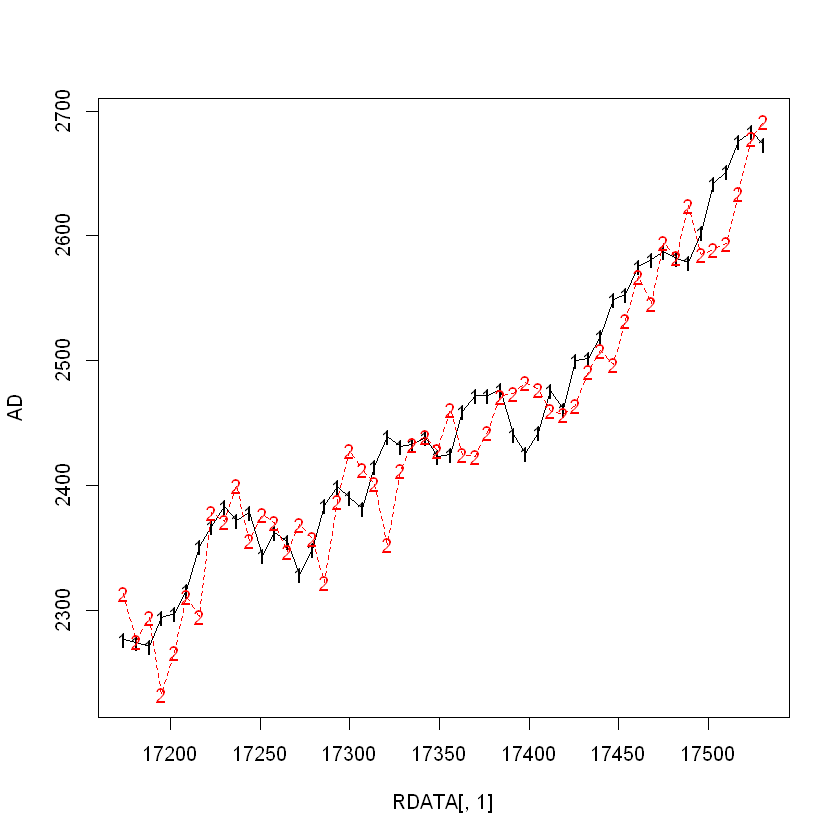

In [21]:
matplot(RDATA[,1],AD,type="o")

In [16]:
AD

RDATA...2.,TDATA...2.
2276.98,2283.56
2274.64,2294.46
2271.31,2300.64
2294.69,2236.21
2297.42,2295.80
2316.10,2327.59
2351.16,2319.25
2367.34,2401.43
2383.12,2373.66
2372.60,2413.29


In [24]:
NT = (AD[,2])[2:52]
ND = (AD[,1])[1:51]
A = (NT-ND)/ND/51
sum(sqrt(A^2))

[1] 0.01123865

In [22]:
NAD <- data.frame(ND,NT)
NAD

ND,NT
2119.12,2110.78
2071.50,2042.61
2085.45,2129.43
2070.77,2006.42
2099.73,2115.84
2152.43,2184.80
2173.02,2179.10
2166.58,2203.89
2163.79,2185.23
2175.49,2160.04


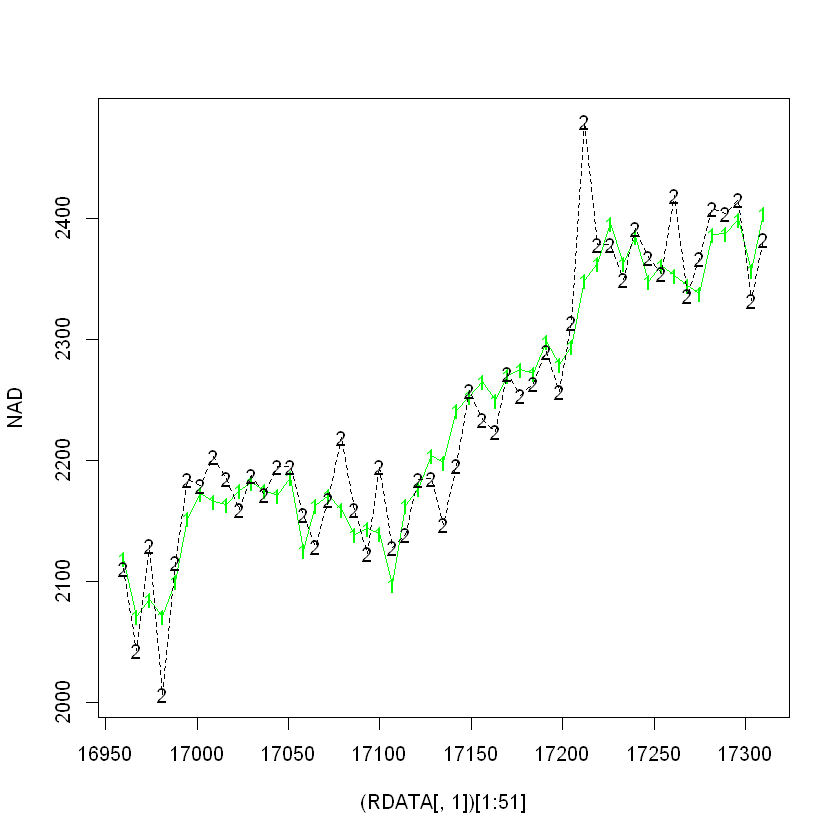

In [23]:
matplot((RDATA[,1])[1:51],NAD,type="o",col = c("green","black"))

In [25]:
28/51

[1] 0.5490196

In [26]:
38/51

[1] 0.745098

In [29]:
RDATA

16960,2119.12
16967,2071.50
16974,2085.45
16981,2070.77
16988,2099.73
16995,2152.43
17002,2173.02
17009,2166.58
17016,2163.79
17023,2175.49
17030,2182.22


In [36]:
as.numeric(as.Date("2015-06-01"))

[1] 16587